<a href="https://colab.research.google.com/github/mthsansu/MLNLP/blob/main/Code/Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center><strong><font color="chillipepper">Parlementarian Sentiment Analysis: Sequence Classification</font></strong></center></h1>
<h3><center><font color="green"><strong>Baseline Model</strong></font></center></h3>

<center>
April 2022, Houri & Sansu
</center>

## <font color="chillipepper">Modules and packages</font>

In [1]:
!pip install datasets

In [2]:
import torch
import numpy as np
import datasets
from datasets import load_dataset
from tqdm import tqdm
import nltk
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer
import pandas as pd
from collections import Counter
import torchtext
from sklearn.model_selection import train_test_split
from termcolor import colored
import torch
import torch.nn as nn
import torch.nn.functional as F

## <font color="chillipepper">Data</font>

**Import the annotated data**

In [3]:
# Import data
git_url = "https://raw.githubusercontent.com/mthsansu/MLNLP/main/Data/"
df = pd.read_csv(git_url + 'df_baseline.csv')

In [4]:
df = df.drop(columns=['Unnamed: 0'])
df = df.rename(columns={'Label': 'label'})

**Prepare the data for machine learning tasks**

In [5]:
train, validate, test = \
              np.split(df.sample(frac=1, random_state=42), 
                       [int(.6*len(df)), int(.8*len(df))])

In [6]:
import pyarrow as pa
import pyarrow.dataset as ds
from datasets import Dataset

# dataset = ds.dataset(pa.Table.from_pandas(df).to_batches())
# dataset = ds.dataset(pa.Table.from_pandas(train).to_batches())

### convert to Huggingface dataset
train_dataset = Dataset(pa.Table.from_pandas(train))

## <font color="chillipepper">Pre-trained Embeddings</font>

**First NLP tasks**

In [7]:
# Run only once: several min long
# fasttext vectors can be imported through torch text (it will download it only once)
from torchtext.vocab import GloVe, vocab, FastText

# pretrained_vectors = GloVe(name="6B", dim='50')
pretrained_vectors = FastText(language='fr')

In [8]:
from torchtext.vocab import GloVe, FastText, vocab

pretrained_vocab = vocab(pretrained_vectors.stoi)
unk_token = "<unk>"
unk_index = 0
pad_token = '<pad>'
pad_index = 1
pretrained_vocab.insert_token("<unk>",unk_index)
pretrained_vocab.insert_token("<pad>", pad_index)
#this is necessary otherwise it will throw runtime error if OOV token is queried 
pretrained_vocab.set_default_index(unk_index)
pretrained_embeddings = pretrained_vectors.vectors
pretrained_embeddings = torch.cat((torch.zeros(1,pretrained_embeddings.shape[1]),pretrained_embeddings))
pretrained_embeddings.size()

torch.Size([1152450, 300])

## <font color="chillipepper">Tokenization</font>

In [9]:
from nltk.tokenize import TweetTokenizer
from tqdm.notebook import tqdm

tok = TweetTokenizer()

In [10]:
def tokenize_pad_numericalize(entry, vocab_stoi, max_length=20):
  text = [ vocab_stoi[token] if token in vocab_stoi else vocab_stoi['<unk>'] for token in tok.tokenize(entry.lower())]
  padded_text = None
  if len(text) < max_length:   padded_text = text + [ vocab_stoi['<pad>'] for i in range(len(text), max_length) ] 
  elif len(text) > max_length: padded_text = text[:max_length]
  else:                        padded_text = text
  return padded_text

def tokenize_all(entries, vocab_stoi):
  res = {}
  res['text'] = [tokenize_pad_numericalize(entry, vocab_stoi, max_length=200) for entry in entries['text']]
  res['label'] = entries['label']
  return res

train_dataset = train_dataset.map(lambda e: tokenize_all(e, pretrained_vocab.get_stoi()), batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [11]:
print(train_dataset['label'])

[1, 0, 1, 0, 1, 1, 2, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 0, 2, 1, 2, 1, 0, 0, 0, 1, 0, 1, 2, 1, 0, 1, 0, 0, 0, 1, 2, 1, 0, 0, 1, 0, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 0, 0, 0, 2, 2, 0, 1, 1, 0, 2, 2, 0, 1, 2, 0, 1, 1, 1, 2, 0, 1, 0, 0, 2, 1, 1, 1, 2, 0, 2, 2, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 0, 2, 1, 1, 2, 0, 1, 2, 0, 2, 2, 0, 1, 1, 0, 0, 0, 1, 1, 1, 2, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 2, 1, 2, 1, 0, 1, 2, 1, 2, 0, 0, 1, 0, 1, 1, 0, 1, 2, 2, 0, 0, 0, 1, 0, 0, 0, 1, 2, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 2, 1, 2, 1, 0, 2, 1, 1, 2, 2, 0, 2, 2, 1, 0, 0, 0, 0, 1, 1, 2, 2, 0, 1, 2, 0, 0, 0, 1, 1, 2, 1, 2, 1, 2, 2, 0, 1, 0, 2, 1, 2, 1, 2, 0, 1, 0, 2, 0, 1, 1, 0, 1, 2, 1, 2, 1, 2, 1, 1, 1, 0, 2, 2, 1, 1, 1, 0, 1, 2, 2, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 2, 1, 0, 0, 1, 0, 1, 2, 2, 0, 1, 1, 2, 2, 1, 2, 1, 0, 1, 0, 0, 2, 0, 1, 1, 0, 0, 0, 2, 1, 0, 2, 0, 0, 1, 0, 1, 1, 2, 0, 1, 1, 0, 2, 2, 1, 0, 1, 1, 2, 0, 1, 0, 2, 1, 

In [12]:
# dataset = ds.dataset(pa.Table.from_pandas(test).to_batches())

### convert to Huggingface dataset
test_dataset = Dataset(pa.Table.from_pandas(test))

# tokenize
test_dataset = test_dataset.map(lambda e: tokenize_all(e, pretrained_vocab.get_stoi()), batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [13]:
print(test_dataset['label'])

[2, 1, 2, 0, 1, 2, 0, 0, 1, 1, 0, 2, 1, 0, 0, 0, 2, 1, 0, 1, 1, 2, 0, 0, 0, 2, 2, 0, 2, 1, 1, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 1, 1, 0, 0, 1, 0, 2, 1, 2, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 1, 0, 1, 2, 0, 0, 0, 2, 2, 1, 0, 2, 1, 0, 1, 1, 2, 2, 1, 0, 0, 0, 0, 1, 2, 1, 1, 1, 1, 1, 2, 0, 0, 2, 1, 1, 2, 1, 0, 1, 1, 0, 0, 1, 2, 2, 1, 1, 0, 1, 2, 2, 2, 2, 1, 1, 0, 0, 0, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 2, 2, 2, 1, 1, 2, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 0, 0, 0, 1, 1, 0, 2, 2, 1, 0, 0, 1, 1, 2, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1]


In [14]:
# dataset = ds.dataset(pa.Table.from_pandas(test).to_batches())

### convert to Huggingface dataset
val_dataset = Dataset(pa.Table.from_pandas(validate))

# tokenize
val_dataset = val_dataset.map(lambda e: tokenize_all(e, pretrained_vocab.get_stoi()), batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [15]:
print(val_dataset['label'])

[2, 1, 2, 0, 1, 0, 2, 0, 1, 2, 1, 2, 0, 0, 0, 2, 1, 1, 0, 2, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 2, 2, 0, 0, 0, 1, 1, 2, 1, 0, 0, 2, 0, 0, 1, 2, 0, 1, 1, 2, 1, 1, 2, 1, 1, 0, 0, 0, 2, 0, 1, 0, 0, 0, 1, 0, 0, 2, 1, 0, 1, 0, 1, 0, 1, 1, 2, 2, 0, 0, 0, 0, 1, 1, 0, 2, 0, 0, 2, 1, 2, 0, 0, 2, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 2, 2, 0, 2, 0, 2, 1, 0, 0, 1, 1, 1, 1, 0, 1, 2, 0, 0, 0, 1, 1, 1, 0, 2, 2, 2, 2, 1, 2, 2, 0, 1, 1, 0, 1, 1, 0, 1, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 1, 1, 1, 0, 0, 2, 1, 0, 2, 0, 1, 2, 2, 2, 0, 0, 1, 0, 0, 2, 0, 1, 1, 0, 2, 0, 2, 1, 2, 0, 0, 1, 1, 2, 2, 0, 0, 0, 0, 0, 1, 0, 2, 0]


## <font color="chillipepper">Building of the model</font>

In [16]:
# Create the Dataset class

from torch.utils.data import Dataset
import numpy as np

class TweetDataset(Dataset):
    def __init__(self, data, args):
      # args is a dict, a nice way to share the global arguments (even accross multiple files)
      self.args = args
      self.data = data

    def __len__(self):
      return len(self.data)
    
    def __getitem__(self, idx):
      item = {
          "text": np.array(self.data[idx]['text']),
          "label": np.array(self.data[idx]['label'])
      }
      # warning: if you put   self.data['text'][idx]    it will take A LOT of time...
      ## The following code would take forever just to print next(iter(train_loader))['text'].shape
      # item = {
      #     "text": np.array(self.data['text'][idx]),
      #     "label": np.array(self.data['label'][idx])
      # }
      return item

In [17]:
# Create the data loader

# Create DataLoader
from torch.utils.data import DataLoader
args = {'bsize': 64}
train_loader = DataLoader(TweetDataset(train_dataset, args), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)
test_loader  = DataLoader(TweetDataset(test_dataset, args), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)
val_loader  = DataLoader(TweetDataset(val_dataset, args), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)

In [18]:
# Define the model to classify tweets

class TweetModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, pretrained_vectors=None):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(TweetModel, self).__init__()
        # apply the pretrained embeddings to transform our token indices, into vectors
        self.ebd = torch.nn.Embedding.from_pretrained(pretrained_vectors, freeze=True)
        self.hidden_linear_layer = torch.nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.classification_layer = torch.nn.Linear(hidden_dim, output_dim, bias=True)
        # softmax layer to compute class probabilities
        # https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html?highlight=softmax#torch.nn.Softmax
        self.softmax = nn.Softmax(dim=1)

        # define the dropout strategy (here, 20% (0.2) of the vector is ignored to prevent overfitting)
        # we don't use it here but it's a good thing to keep in mind
        # self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        # apply the pretrained embeddings
        x  = self.ebd(x)
        x  = x.mean(1)
        h  = torch.relu(self.hidden_linear_layer( x ))
        # h  = self.dropout(h)
        h  = self.classification_layer(h)
        logits = self.softmax(h)
        return logits

In [19]:
sizes = next(iter(train_loader))['text'].size()
batchsize = sizes[0]
inputdim  = sizes[1]
print(batchsize, inputdim)

64 200


In [20]:
hiddendim = 300 # dimension of the pretrained vector
outputdim = 3 # because there is 3 classes, i.e. 3 labels
# we instanciate the model
tweet_model = TweetModel(inputdim, hiddendim, outputdim, pretrained_vectors=pretrained_vectors.vectors)

In [21]:
# we can look at the model 
tweet_model

TweetModel(
  (ebd): Embedding(1152449, 300)
  (hidden_linear_layer): Linear(in_features=300, out_features=300, bias=True)
  (classification_layer): Linear(in_features=300, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)

**We'll need a GPU**

In [22]:
if torch.cuda.is_available():
  device = 'cuda'
  print('DEVICE = ', colored(torch.cuda.get_device_name(0), "green" ) )
else:
  device = 'cpu'
  print('DEVICE = ', colored('CPU', "blue"))
tweet_model.to(device)

DEVICE =  Tesla K80


TweetModel(
  (ebd): Embedding(1152449, 300)
  (hidden_linear_layer): Linear(in_features=300, out_features=300, bias=True)
  (classification_layer): Linear(in_features=300, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)

**Train the model**

In [23]:
# Training loop

def train(model, optimizer, ep, args):
  # set the model into a training mode : the model's weights and parameters WILL BE updated!
  model.train()
  # initialize empty lists for losses and accuracies
  loss_it, acc_it = list(), list()

  # start the loop over all the training batches. This means one full epoch.
  for it, batch in tqdm(enumerate(train_loader), desc="Epoch %s:" % (ep), total=train_loader.__len__()):
    
    batch = {'text': batch['text'].to(device), 'label': batch['label'].to(device)}

    # put parameters of the model and the optimizer to zero before doing another iteration. this prevents the gradient accumulation through batches
    optimizer.zero_grad()

    # apply the model on the batch
    logits = model(batch['text'])

    # # # to deal with unbalanced data in the batch, we calculate the weights according to their inverse frequency
    b_counter = Counter(batch['label'].detach().cpu().tolist())
    b_weights = torch.tensor( [ sum(batch['label'].detach().cpu().tolist()) / b_counter[label] if b_counter[label] > 0 else 0 for label in list(range(args['num_class'])) ] )
    b_weights = b_weights.to(device)

    # we choose the CrossEntropyLoss, suitable for multiclass classification
    # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss
    loss_function = nn.CrossEntropyLoss(weight=b_weights)
    # loss_function = nn.CrossEntropyLoss()
    loss = loss_function(logits, batch['label'])

    # compute backpropagation
    loss.backward()

    # indicate to the optimizer we've done a step
    optimizer.step()

    # append the value of the loss for the current iteration (it). .item() retrieve the nuclear value as a int/long
    loss_it.append(loss.item())

    # get the predicted tags using the maximum probability from the softmax
    _, tag_seq  = torch.max(logits, 1)
    
    # Those 3 lines compute the accuracy and then append it the same way as the loss above
    correct = (tag_seq.flatten() == batch['label'].flatten()).float().sum()
    acc = correct / batch['label'].flatten().size(0)
    acc_it.append(acc.item())

  # simple averages of losses and accuracies for this epoch
  loss_it_avg = sum(loss_it)/len(loss_it)
  acc_it_avg = sum(acc_it)/len(acc_it)
  
  # print useful information about the training progress and scores on this training set's full pass (i.e. 1 epoch)
  print("Epoch %s/%s : %s : (%s %s) (%s %s)" % (colored(str(ep), 'blue'),args['max_eps'] , colored('Training', 'blue'), colored('loss', 'cyan'), sum(loss_it)/len(loss_it), colored('acc', 'cyan'), sum(acc_it) / len(acc_it)))


In [24]:
def inference(target, loader, model):
  """
    Args:
      target (str): modify the display, usually either 'validation' or 'test'
  """

  # set the model into a evaluation mode : the model's weights and parameters will NOT be updated!
  model.eval()

  # intialize empty list to populate later on
  loss_it, acc_it, f1_it = list(), list(), list()
  # preds = predicted values ; trues = true values .... obviously~
  preds, trues = list(), list()

  # loop over the loader batches
  for it, batch in tqdm(enumerate(loader), desc="%s:" % (target), total=loader.__len__()):
    # set an environnement without any gradient. So the tensor gradients are not considered 
    # (saves a lot of computation and memory, this is one of the many things that makes predicting far less costly than training)
    with torch.no_grad():

      # put the batch to the correct device
      batch = {'text': batch['text'].to(device), 'label': batch['label'].to(device)}

      # apply the model
      logits = model(batch['text'])

      # # to deal with unbalanced data in the batch, we calculate the weights according to their inverse frequency
      # b_counter = Counter(batch['label'].detach().cpu().tolist())
      # b_weights = torch.tensor( [ sum(batch['label'].detach().cpu().tolist()) / b_counter[label] if b_counter[label] > 0 else 0 for label in list(range(20)) ] )
      # b_weights = b_weights.to(device)

      # loss_function = nn.CrossEntropyLoss(weight=b_weights)
      loss_function = nn.CrossEntropyLoss()
      loss = loss_function(logits, batch['label'])

      # no need to backward() and other training stuff. Directly store the loss in the list
      loss_it.append(loss.item())

      # get the predicted tags using the maximum probability from the softmax
      _, tag_seq  = torch.max(logits, 1)
      
      # compute the accuracy and store it
      correct = (tag_seq.flatten() == batch['label'].flatten()).float().sum()
      acc = correct / batch['label'].flatten().size(0)
      acc_it.append(acc.item())
      
      # extend the predictions and true labels lists so we can compare them later on
      # note how we first ensure the tensor are on cpu (.cpu()), then we detach() the gradient from the tensor, before transforming it to a simple python list (.tolist())
      preds.extend(tag_seq.cpu().detach().tolist())
      trues.extend(batch['label'].cpu().detach().tolist())

  # compute the average loss and accuracy accross the iterations (batches)
  loss_it_avg = sum(loss_it)/len(loss_it)
  acc_it_avg = sum(acc_it)/len(acc_it)
  
  # print useful information. Important during training as we want to know the performance over the validation set after each epoch
  print("%s : (%s %s) (%s %s)" % ( colored(target, 'blue'), colored('loss', 'cyan'), sum(loss_it)/len(loss_it), colored('acc', 'cyan'), sum(acc_it) / len(acc_it)))

  # return the true and predicted values with the losses and accuracies
  return trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it

In [44]:
# Start training

import torch.optim as optim

def run_epochs(model, args):

  # args['device'] =device
  if args['cuda'] != -1:
      model.cuda(args['cuda'])
      device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      args['device'] = device
      print("device set to %s" % (device) )

  # we set the optimizer as Adam with the learning rate (lr) set in the arguments
  # you can look at the different optimizer available here: https://pytorch.org/docs/stable/optim.html
  optimizer = optim.Adam(model.parameters(), lr = args['lr'])

  # define an empty list to store validation losses for each epoch
  val_ep_losses = list()
  # iterate over the number of max epochs set in the arguments
  for ep in range(args['max_eps']):
    # train the model using our defined function
    train(model, optimizer, ep, args)
    # apply the model for inference using our defined function
    trues, preds, val_loss_it_avg, val_acc_it_avg, val_loss_it, val_acc_it = inference("validation", val_loader, model)
    # append the validation losses (good losses should normally go down)
    val_ep_losses.append(val_loss_it_avg)

  # return the list of epoch validation losses in order to use it later to create a plot
  return val_ep_losses
    

In [45]:
# here you can specify if you want a GPU or a CPU by setting the cuda argument as -1 for CPU and another index for GPU. If you only have one GPU, put 0.
args.update({'max_eps': 80, 'lr': 0.001, 'device': 'gpu', 'cuda': 0, 'num_class': 3})
# 1e-05
print('device', device)
# Instantiate model with pre-trained glove vectors
# model = TweetModel(pretrained_embeddings, args['num_class'], args, dimension=50, freeze_embeddings = True )
tweet_model = TweetModel(inputdim, hiddendim, outputdim, pretrained_vectors=pretrained_vectors.vectors)
loss_list_val = run_epochs(tweet_model, args)

device cuda
device set to cuda


Epoch 0::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 0/80 : Training : (loss 1.0978286398781671) (acc 0.3489583333333333)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.095674991607666) (acc 0.4479166666666667)


Epoch 1::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/80 : Training : (loss 1.0957213242848713) (acc 0.3888888888888889)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.09347931543986) (acc 0.4270833333333333)


Epoch 2::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/80 : Training : (loss 1.0920737716886733) (acc 0.3993055555555556)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0933879613876343) (acc 0.3958333333333333)


Epoch 3::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/80 : Training : (loss 1.0876291063096788) (acc 0.4027777777777778)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0893702109654744) (acc 0.3958333333333333)


Epoch 4::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/80 : Training : (loss 1.0804722441567316) (acc 0.4114583333333333)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0905786752700806) (acc 0.3854166666666667)


Epoch 5::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/80 : Training : (loss 1.075114541583591) (acc 0.4079861111111111)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0766748984654744) (acc 0.421875)


Epoch 6::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 6/80 : Training : (loss 1.068933950530158) (acc 0.4097222222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0683559974034627) (acc 0.40625)


Epoch 7::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 7/80 : Training : (loss 1.0638086001078289) (acc 0.4131944444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0625756581624348) (acc 0.4270833333333333)


Epoch 8::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 8/80 : Training : (loss 1.0618256330490112) (acc 0.4236111111111111)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0632867415746052) (acc 0.421875)


Epoch 9::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 9/80 : Training : (loss 1.0581175883611043) (acc 0.4131944444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0748121341069539) (acc 0.40625)


Epoch 10::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10/80 : Training : (loss 1.054424974653456) (acc 0.4618055555555556)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0703440109888713) (acc 0.4322916666666667)


Epoch 11::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 11/80 : Training : (loss 1.0489931503931682) (acc 0.4392361111111111)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.073086420694987) (acc 0.4166666666666667)


Epoch 12::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 12/80 : Training : (loss 1.0486054685380723) (acc 0.4409722222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.064820130666097) (acc 0.3854166666666667)


Epoch 13::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 13/80 : Training : (loss 1.047746671570672) (acc 0.4635416666666667)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0688287417093914) (acc 0.4322916666666667)


Epoch 14::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 14/80 : Training : (loss 1.046539094712999) (acc 0.4600694444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0684558550516765) (acc 0.3958333333333333)


Epoch 15::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 15/80 : Training : (loss 1.0425371726353962) (acc 0.4409722222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0783700942993164) (acc 0.40625)


Epoch 16::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 16/80 : Training : (loss 1.0436230897903442) (acc 0.4913194444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0949209133783977) (acc 0.375)


Epoch 17::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 17/80 : Training : (loss 1.0369011163711548) (acc 0.4479166666666667)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.080142577489217) (acc 0.4010416666666667)


Epoch 18::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 18/80 : Training : (loss 1.0356360011630588) (acc 0.4947916666666667)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0839637517929077) (acc 0.4010416666666667)


Epoch 19::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 19/80 : Training : (loss 1.0360302262836032) (acc 0.4652777777777778)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0803296566009521) (acc 0.4010416666666667)


Epoch 20::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 20/80 : Training : (loss 1.0314288867844477) (acc 0.4930555555555556)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0736072460810344) (acc 0.4010416666666667)


Epoch 21::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 21/80 : Training : (loss 1.0303959714041815) (acc 0.4583333333333333)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0769356886545818) (acc 0.4114583333333333)


Epoch 22::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 22/80 : Training : (loss 1.0264848603142633) (acc 0.5086805555555556)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0571683247884114) (acc 0.4166666666666667)


Epoch 23::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 23/80 : Training : (loss 1.0276819401317172) (acc 0.5208333333333334)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.057820161183675) (acc 0.4322916666666667)


Epoch 24::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 24/80 : Training : (loss 1.033907135327657) (acc 0.4583333333333333)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0773171583811443) (acc 0.390625)


Epoch 25::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 25/80 : Training : (loss 1.0246598256958857) (acc 0.5364583333333334)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.066593607266744) (acc 0.4166666666666667)


Epoch 26::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 26/80 : Training : (loss 1.025318490134345) (acc 0.515625)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0735392967859905) (acc 0.3854166666666667)


Epoch 27::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 27/80 : Training : (loss 1.0182645916938782) (acc 0.5)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.073780099550883) (acc 0.40625)


Epoch 28::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 28/80 : Training : (loss 1.017828146616618) (acc 0.5260416666666666)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0651549100875854) (acc 0.40625)


Epoch 29::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 29/80 : Training : (loss 1.0161098904079862) (acc 0.5243055555555556)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0710546970367432) (acc 0.40625)


Epoch 30::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 30/80 : Training : (loss 1.0153404143121507) (acc 0.5486111111111112)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.05850084622701) (acc 0.4270833333333333)


Epoch 31::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 31/80 : Training : (loss 1.020531502034929) (acc 0.5538194444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0850181976954143) (acc 0.390625)


Epoch 32::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 32/80 : Training : (loss 1.0140331983566284) (acc 0.5295138888888888)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0774143139521282) (acc 0.390625)


Epoch 33::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 33/80 : Training : (loss 1.0146560933854845) (acc 0.5052083333333334)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0644787549972534) (acc 0.4322916666666667)


Epoch 34::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 34/80 : Training : (loss 1.0100795427958171) (acc 0.5225694444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0735029379526775) (acc 0.4166666666666667)


Epoch 35::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 35/80 : Training : (loss 1.0070937474568684) (acc 0.5260416666666666)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0754503011703491) (acc 0.3854166666666667)


Epoch 36::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 36/80 : Training : (loss 1.0066886345545452) (acc 0.5486111111111112)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0670292774836223) (acc 0.4010416666666667)


Epoch 37::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 37/80 : Training : (loss 1.0055058863427904) (acc 0.5555555555555556)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.08580748240153) (acc 0.3802083333333333)


Epoch 38::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 38/80 : Training : (loss 0.9979881048202515) (acc 0.5729166666666666)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.065262993176778) (acc 0.390625)


Epoch 39::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 39/80 : Training : (loss 1.0050410893228319) (acc 0.5486111111111112)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0754363934199016) (acc 0.4322916666666667)


Epoch 40::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 40/80 : Training : (loss 0.9949027895927429) (acc 0.5434027777777778)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0660032828648884) (acc 0.4322916666666667)


Epoch 41::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 41/80 : Training : (loss 0.9943116969532437) (acc 0.59375)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.06966237227122) (acc 0.3854166666666667)


Epoch 42::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 42/80 : Training : (loss 0.9934820400344001) (acc 0.5694444444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0661828915278118) (acc 0.390625)


Epoch 43::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 43/80 : Training : (loss 0.9949090480804443) (acc 0.5677083333333334)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.074860692024231) (acc 0.40625)


Epoch 44::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 44/80 : Training : (loss 0.9879381987783644) (acc 0.5885416666666666)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.074904998143514) (acc 0.4010416666666667)


Epoch 45::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 45/80 : Training : (loss 0.9925435781478882) (acc 0.5642361111111112)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0767618815104167) (acc 0.40625)


Epoch 46::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 46/80 : Training : (loss 0.9873836504088508) (acc 0.59375)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0624324878056843) (acc 0.3854166666666667)


Epoch 47::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 47/80 : Training : (loss 0.9921461873584323) (acc 0.5711805555555556)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0956337849299114) (acc 0.359375)


Epoch 48::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 48/80 : Training : (loss 0.9923495054244995) (acc 0.5729166666666666)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0618813037872314) (acc 0.4114583333333333)


Epoch 49::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 49/80 : Training : (loss 0.9901546107398139) (acc 0.5885416666666666)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.089133580525716) (acc 0.3802083333333333)


Epoch 50::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 50/80 : Training : (loss 0.9815021819538541) (acc 0.5850694444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0670239925384521) (acc 0.4322916666666667)


Epoch 51::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 51/80 : Training : (loss 0.9791962703069051) (acc 0.6006944444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0661044120788574) (acc 0.3958333333333333)


Epoch 52::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 52/80 : Training : (loss 0.978656636344062) (acc 0.5815972222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0704667170842488) (acc 0.4427083333333333)


Epoch 53::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 53/80 : Training : (loss 0.9775108959939744) (acc 0.5833333333333334)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.066944162050883) (acc 0.40625)


Epoch 54::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 54/80 : Training : (loss 0.9771689971288046) (acc 0.5902777777777778)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0677212476730347) (acc 0.390625)


Epoch 55::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 55/80 : Training : (loss 0.9735454254680209) (acc 0.5885416666666666)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.088109294573466) (acc 0.3854166666666667)


Epoch 56::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 56/80 : Training : (loss 0.9772901866171095) (acc 0.5538194444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.085546851158142) (acc 0.3958333333333333)


Epoch 57::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 57/80 : Training : (loss 0.9686212738355001) (acc 0.5989583333333334)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0805441935857136) (acc 0.390625)


Epoch 58::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 58/80 : Training : (loss 0.9766562249925401) (acc 0.5555555555555556)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0842010180155437) (acc 0.375)


Epoch 59::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 59/80 : Training : (loss 0.9767643080817329) (acc 0.5572916666666666)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0653572082519531) (acc 0.4166666666666667)


Epoch 60::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 60/80 : Training : (loss 0.9694644080268012) (acc 0.5833333333333334)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0683724880218506) (acc 0.4166666666666667)


Epoch 61::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 61/80 : Training : (loss 0.971154703034295) (acc 0.5902777777777778)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0597979227701824) (acc 0.4427083333333333)


Epoch 62::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 62/80 : Training : (loss 0.9727654192182753) (acc 0.6041666666666666)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.082917332649231) (acc 0.4270833333333333)


Epoch 63::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 63/80 : Training : (loss 0.9681550396813287) (acc 0.59375)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0730289618174236) (acc 0.4479166666666667)


Epoch 64::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 64/80 : Training : (loss 0.9576885302861532) (acc 0.5815972222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.076433539390564) (acc 0.4375)


Epoch 65::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 65/80 : Training : (loss 0.9625904030270047) (acc 0.5972222222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0569414695103962) (acc 0.4583333333333333)


Epoch 66::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 66/80 : Training : (loss 0.9655111167165968) (acc 0.5850694444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0747017463048298) (acc 0.4322916666666667)


Epoch 67::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 67/80 : Training : (loss 0.9666546583175659) (acc 0.5902777777777778)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.070820689201355) (acc 0.4375)


Epoch 68::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 68/80 : Training : (loss 0.9595461553997464) (acc 0.6041666666666666)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0854222377141316) (acc 0.4010416666666667)


Epoch 69::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 69/80 : Training : (loss 0.9559241135915121) (acc 0.6163194444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0882110198338826) (acc 0.3802083333333333)


Epoch 70::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 70/80 : Training : (loss 0.9611788524521722) (acc 0.6076388888888888)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0734021266301472) (acc 0.421875)


Epoch 71::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 71/80 : Training : (loss 0.9532733228471544) (acc 0.6180555555555556)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0709598859151204) (acc 0.421875)


Epoch 72::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 72/80 : Training : (loss 0.9544755750232272) (acc 0.5885416666666666)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0642988681793213) (acc 0.4270833333333333)


Epoch 73::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 73/80 : Training : (loss 0.9608416226175096) (acc 0.5798611111111112)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0852363506952922) (acc 0.4114583333333333)


Epoch 74::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 74/80 : Training : (loss 0.9513179262479147) (acc 0.6267361111111112)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.067080060640971) (acc 0.453125)


Epoch 75::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 75/80 : Training : (loss 0.9504655533366733) (acc 0.6128472222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0797733863194783) (acc 0.421875)


Epoch 76::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 76/80 : Training : (loss 0.9594263633092245) (acc 0.5972222222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0765044689178467) (acc 0.4114583333333333)


Epoch 77::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 77/80 : Training : (loss 0.9511492782168918) (acc 0.6232638888888888)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.084918777147929) (acc 0.3958333333333333)


Epoch 78::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 78/80 : Training : (loss 0.9492761625183953) (acc 0.6111111111111112)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.071582317352295) (acc 0.4427083333333333)


Epoch 79::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 79/80 : Training : (loss 0.9524117244614495) (acc 0.6059027777777778)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0687988996505737) (acc 0.421875)


**Evaluate the model**

In [46]:
# let's use our model for inference on the test set. We can short it by naming it "test our model"
# we set the target as "test" to print the correct info, and use the test loader
trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it = inference("test", test_loader, tweet_model)

test::   0%|          | 0/3 [00:00<?, ?it/s]

test : (loss 1.0080524484316509) (acc 0.515625)


In [47]:
set(preds)

{0, 1, 2}

In [48]:
names = [0,1,2]

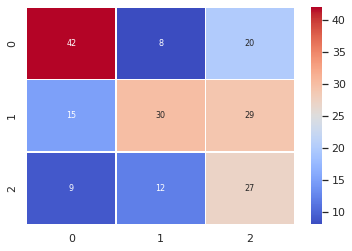

In [49]:
# Confusion matrix

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, plot_roc_curve
import matplotlib.pyplot as plt
import seaborn as sn

cm = confusion_matrix(np.array(trues).flatten(), np.array(preds).flatten())
df_cm = pd.DataFrame(cm, index=names, columns=names)
# config plot sizes
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8}, cmap='coolwarm', linewidth=0.5, fmt="")
plt.show()